###### Bayes: Conjugacy

All of the previous examples of bayesian inference that we've used have been very simple. In fact, we've been able to solve all of them by hand! But the real world is messy. Over the enxt few examples we'll discuss how to deal with some of this messiness starting with a simple example. 

Let's review Bayes Theorem:

$P(A|B)=\frac{P(A)*P(B|A)}{P(B)}$

We refered to P(B) as the evidence (some refer to it as the marginal liklihood or normalizing constant). Let's write it out in it's more useful form:

$P(B)={\int_0^1 p(B,A)}dA={\int_0^1 p(B|A)p(A)dA}={\int_0^1 A^{10}p(A)dA}$

It's pretty obvious that our ability to solve this integral depends on the form of our liklihood and prior. In fact, except for a few special cases, there is no clsoed form solution for this integral! We'll later see that there are alternative ways to use Bayes Theorem other than through the clsoed form (or analytical) solution. For now, let's look at one of the special cases where we do have a closed form solution. 

Let's assume that we have some normally distributed data with a known variance of one. Our sample data consists of twenty data points. A histogram of the data is shown below.

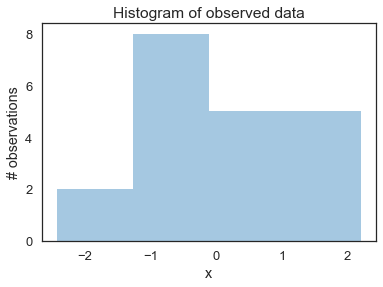

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)
data = np.random.randn(20)

ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Given that we know the standard deviation, let's solve for the mean of the distribution. Since we have our Bayes hats on, we're going to solve for the probability distribution of the mean of our data, rather than a point estiamte or confidence interval. 

Now the form of our liklihood is rather obvious since we already assumed that the data is normally distributed:

$\mu \sim \text{Normal}(0, 1)$

But what should we use as our prior? We could use a uniform prior, which would be like saying that we have no intuition about what the mean of our data should be before we collected our data. This might be a perfectly reasonable prior. 

To help come up with a more informative prior, I'll add a little more color to our example. Let's say that we are electrical engineers and we've stumpled on a troubesome ground wire in our circuit. By this I mean that we have a wire in our circuit that should have a relative voltage of zero with some gaussian distributed noise around it. Unfortunately, we think that the ground wire isn't actually at a relative ground voltage of zero! So we collect some voltage readings and that is our data. 

Maybe you're now getting some ideas for what a more informative prior might look like! Well, let's assume that my strongest prior belief is that the mean of the data is at zero, as it should be if the circuit is functioning. However, I still have a reasonable amount of belief that the mean is not zero. Since I can honestly say that I don't believe that the mean is infinity or negative infinity, I might want to choose a symetric distribution that quickly drops off as it approaches large magnitudes. 

Well, that sounds awfully like the normal distribution! 

$x|\mu \sim \text{Normal}(x; \mu, 1)$

Now this is very convenient, because a normal prior forms 'conjugacy' with a normal liklihood! You can find a rather comprehensive list of conjugate priors [here](https://en.wikipedia.org/wiki/Conjugate_prior). I will caution you that I, having a physics background, found much of the notation unintuitive. Bayesian statisticians can label things strangely, so be careful of defininitions. 

Now if you want to be lazy, that page will give you the calulation for the posterior given a Normal conjugate prior...but shame on you for being lazy! The more adventerous can find the derivation in section two of this [paper](http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf). I encourage you to walk through it as it is one of the simpler conjugate priors. You could also try walking through the Beta conjugate prior derivation [here](https://courses.engr.illinois.edu/cs598jhm/sp2010/Slides/Lecture02HO.pdf). The binomial distibution is often used to model coin flipping or success rate problems. 

We can solve for the mean and variance of our posterior using the following formulas:

$\mu_{posterior} = \frac{1}{\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}}(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^{n} x_i}{\sigma^2})$

$\sigma_{posterior} = \frac{1}{\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}}$

$\sigma_0$ = standard deviation of prior <br/>
$\mu_0$ = mean of prior <br/>
$x_i$ = observtions <br/>
$n$ = number of observations <br/>

We could rewrite these equations using the precision ($\tau=\frac{1}{\sigma^2}$). This parameterization yields an interesting insight.

$\mu_{posterior} = \frac{\tau_0 \mu_0 + \tau \sum_{i=1}^{n} x_i}{\tau_0 + n \tau}$

$\tau_{posterior} = \tau_0 + n \tau$

It looks like our posterior is just a linear combination of our prior and observations! Not only that, but this averaging on the prior and observations is weighted by n. This means that the more observations we see, the more we will believe our observations over our liklihood. This is better than HBO!

Let's put this into code:

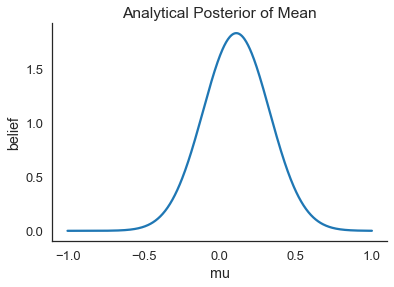

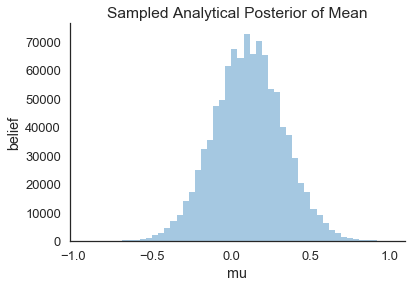

In [2]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical,label='analytical posterior')
ax.set(xlabel='mu', ylabel='belief', title='Analytical Posterior of Mean');
sns.despine()
plt.show()

# It can be dificult to deal with the posterior in this form, 
# so let's sample the posterior to make it easier to manipulate in numpy
p = posterior_analytical
p = p / p.sum()
posterior_analytical_sampled = np.random.choice(a=x,p=p,size=1000000)

ax = plt.subplot()
sns.distplot(posterior_analytical_sampled,label='sampled analytical posterior',kde=False)
ax.set(xlabel='mu', ylabel='belief', title='Sampled Analytical Posterior of Mean');
sns.despine()
plt.show()

Now what can we do with that? We originally wanted to know what the mean of our data was so that we could know if the ground wire actually had a relative voltage of zero. However, we now have a distribution!

Well, we could always take a point estimate and compare that to zero. While Bayesians aren't big fans of point estimates (because you neccessarily lose information by summarizing a distribution as a point), they sometimes use the maximum a posteriori (MAP). This is the most likely parameter in your distribution. We can easily find this point by taking the mode of the sampled posterior. 

In [3]:
print "MAP: {}".format( sp.stats.mode( np.round(posterior_analytical_sampled,2) )[0][0] )
print "AVG: {}".format( np.round(np.mean(posterior_analytical_sampled),3) )

MAP: 0.11
AVG: 0.109


Depending on the tolerance of our circuit to a faulty ground point, this may or may not be worrisome. It's worth noting that for a symetrical distribution with one maxima, such as a gaussian, the mean should equal the MAP. If you take a clsoe look at my code, you should notice a few obvious reasons why the mean does not equal the MAP (hint: what approximations am I making to calculate the mean and MAP of the posterior?).

Now, if we don't want a point estimate, then we can just calculate the crediblity interval. We can do this by rank ordering the samples of the posterior and finding the 2.5 percentile value and the 97.5 percentile value (assuming we want 95% credibility).

In [5]:
lower_bound = round(np.percentile(posterior_analytical_sampled,2.5), 3) 
upper_bound = round(np.percentile(posterior_analytical_sampled,97.5), 3)
print "95% Credibility Interval: [{}, {}]".format(lower_bound, upper_bound)

95% Credibility Interval: [-0.319, 0.535]


Well that isn't looking so great! Maybe we should colelct more than 20 samples. I'll leave that exercise up to you. 

One last note on conjugacy: It's not magic. Conjugacy is merely a convenient math trick that we can sometimes employ. When approaching a bayesian stats problem, first try to udnerstand the problem at a high level. Build intuition about what is happening and what you think the prior and liklihood should look like. Are they symmetric? Are they skewed (mean $\neq$ median)? 

After you understand the problem, look for conjugate relationships. Do any of the known conjugate priors fit your intuition of the problem? If they don't, you shouldn't force bad assumptions on your test. We'll talk about solving bayes Theorem without conjugate priors in our next example. For now, try solving the coin flipping problem. What is the probability of getting heads? (**SPOILER ALERT**: try a binomial liklihood and beta prior)

###### Bayes: Metropolis Hastings Sampling

Author's Note: I draw heavily from Thomas Wiecki's blog post on this subject for the rest of this section.

So far we've walked through a few different solutions for Bayes Theorem. In our earliest examples we had very simple liklihoods and priors. This let use directly calculate the intergral of the marginal lklihood (evidence) and solve for the posterior. We then moved on to more complicated liklihoods and priors where we needed to really think through the math to solve for the posterior. It turned out that, for some of these more complicated examples, we can find a special mathematical relationship between the prior and liklihood that helped make the calculation of the evidence tractible. 

So what if the problem is complicated and we can't find a conjugate prior? Well, then we get to try someting super cool: Markov Chain Monte Carlo (MCMC) Sampling. Now this sounds very intimidating, but it doesn't have to be. We're going to walk through the simplest MCMC sampling method, Metropolis Hastings (MH), step by step.

In the end, you'll see that it's just all dice rolls and record keeping. 

We'll begin with the same use case as the last example. We have data of known standard deviation but unknown mean. How do we get the posterior of the mean? In the last example we solved for the posterior of the mean analytically. In this example, we're going to indirectly sample the posterior of the mean to approximate it. 

Bayes Theorem: <br/>
$P(A|B)=\frac{P(A)*P(B|A)}{P(B)}$

Now remember that the evidence, P(B), is the troublesome component. We can't calculate the integral needed to solve for P(B).

$P(B) = \int_A P(B, A) \, \mathrm{d}A =$ ?

But let's say that we broke the distribution of A down into individual values. We'll only consider two values: A_C and A_P. 

$P(A_C|B)=\frac{P(A_C)*P(B|A_C)}{P(B)}$

$P(A_P|B)=\frac{P(A_P)*P(B|A_P)}{P(B)}$

We can then divide the second equation by the first.

$\frac{P(A|B_P)}{P(A|B)}=\frac{\frac{P(A_P)*P(B|A_P)}{P(B)}}{\frac{P(A_C)*P(B|A_C)}{P(B)}}=\frac{P(A_P)*P(B|A_P)}{P(A_C)*P(B|A_C)}$

Abracadabra! That nasty integral disapeared! Well neato, but how does that help us solve for the posterior? Take a look at that equation. The relative probabilites of each value in the posterior are rqual to the relative probabilities of each value in the liklihood tiems the prior. 

Said another way, if we randomly generate values (let's say we just roll a many sided die), we can calculate the relative probability that each value came from the posterior. Well that's the [Mote Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) portion of MCMC. What about the Markov Chain?

To bring in the [Markov chain]() component we only need to change one aspect of our procedure. Instead of completely randomly generating values, we'll generate take ranom steps from the last value generated. For example, if we initially pick a value 1/2, we randomly pick a new value +/- 1 step size away from 1/2. Then we look at the relative probability that each value came from the psoterior. If the new proposal has a higher probability, then we accept it and add it to the markov chain. We then take a random step away from that value. What we'll end up with is an array of values where each value is more probable than the last. 

Those familiar with optimization functions or machine learning will recognize this as a hill climbing algorithm. Let's try looking at this process in action. At each iteration of our sampling we display four plots. 

The first plot shouws where our current and proposed values fall on our prior. We color the current value blue and the proposal as either green or red (green if accepted and red if rejected). If the proposal is accepted it becomes the new current value. 

The second plot displays our data and the proposal distribution (in this case a normal distribution with a mean of the proposed value). You'll notice that as we iterate the proposed distribution better fits the data.

Third we have our posterior. After ~10 iterations we each our MAP, as expected. Finally we plot our trace. The trace displays all of the values in our markov chain! Since we are only accepting, it will increase monotonically until we reach the MAP and then it will plateau. 

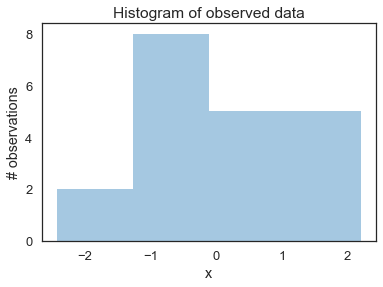

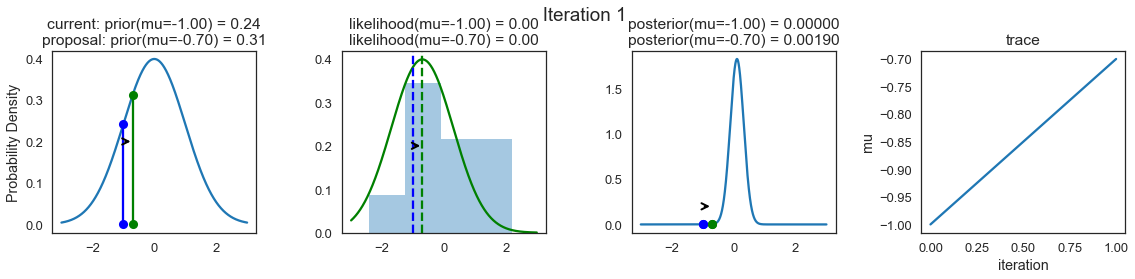

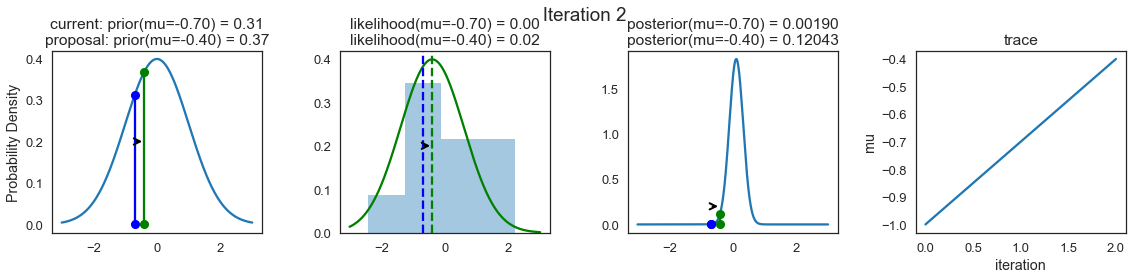

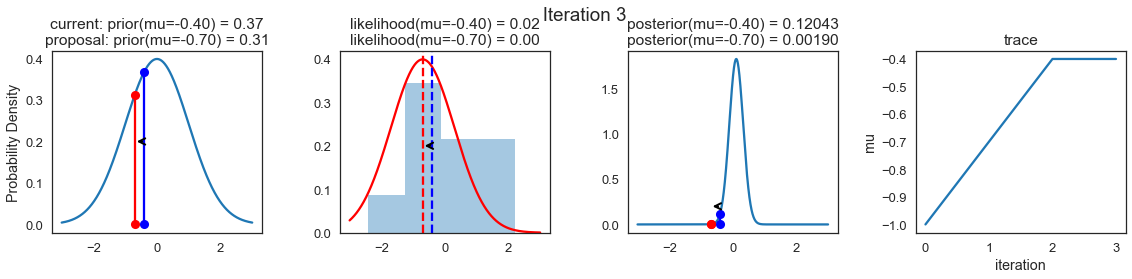

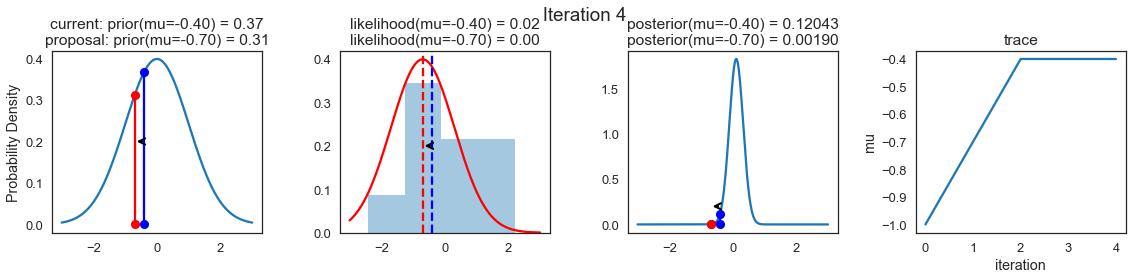

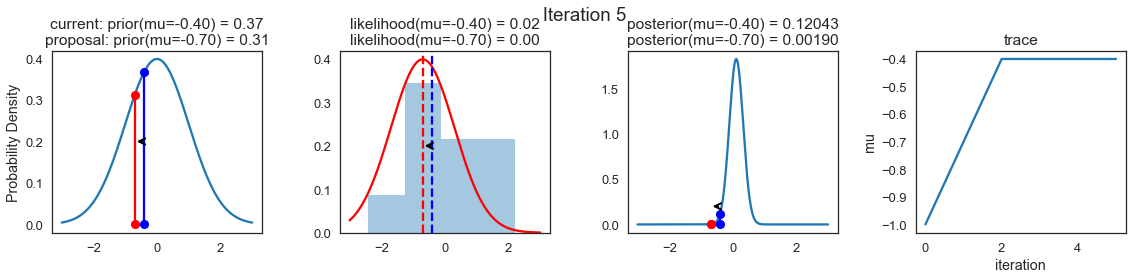

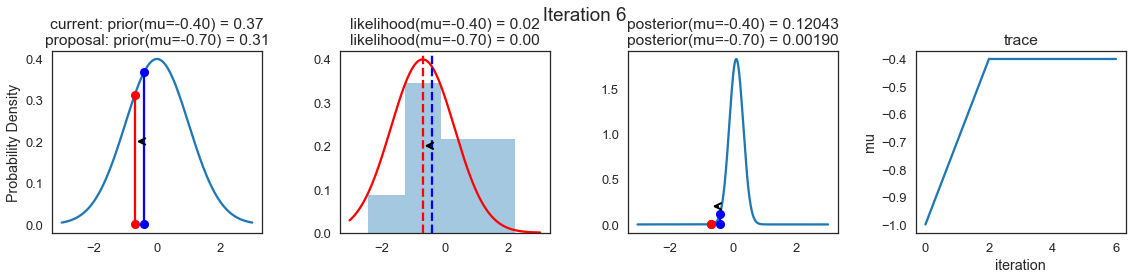

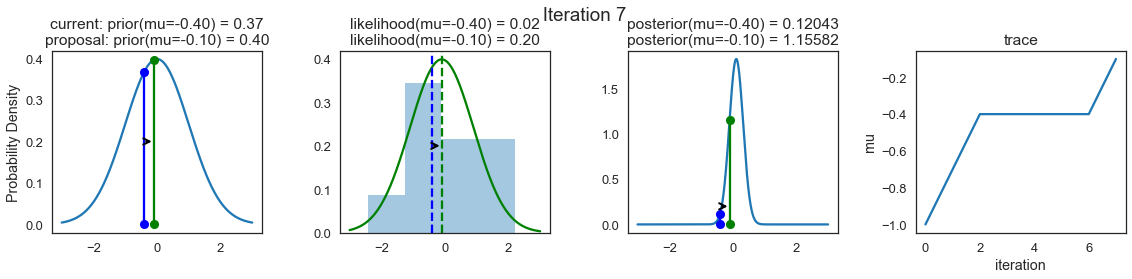

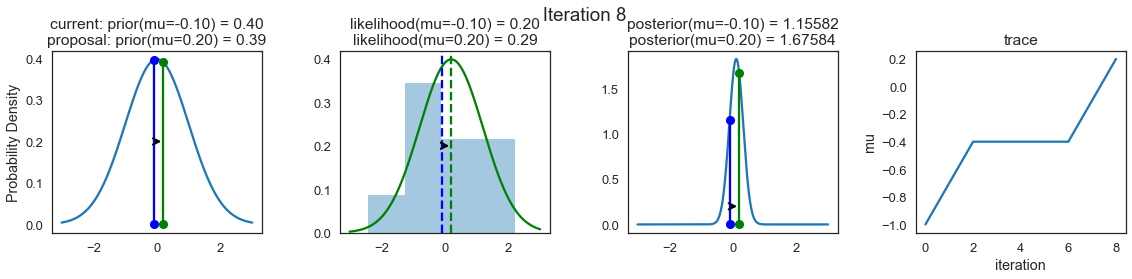

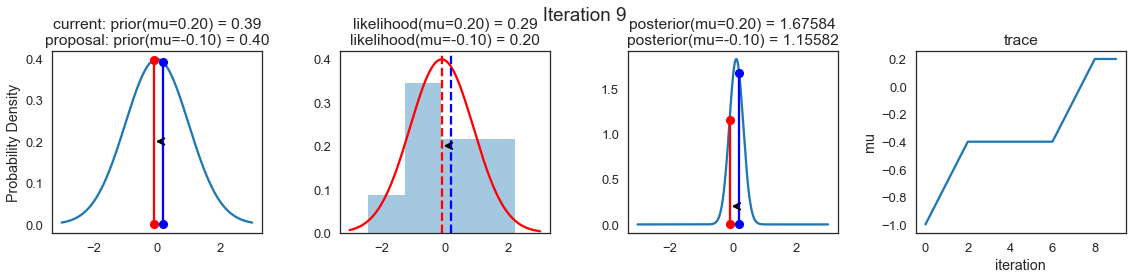

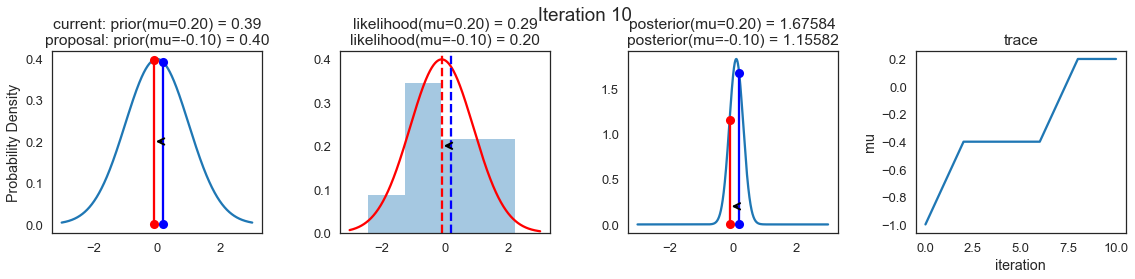

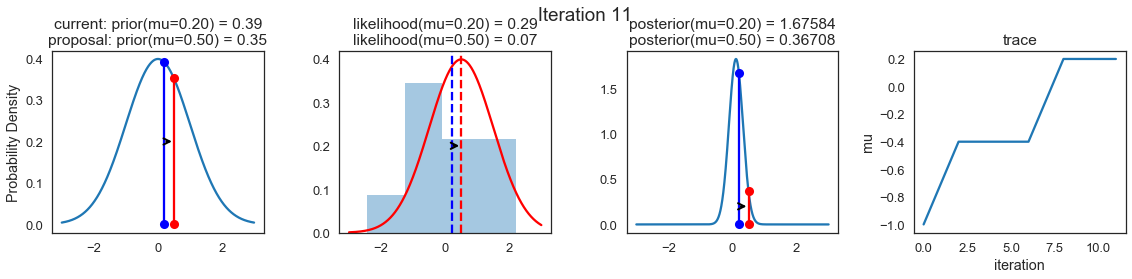

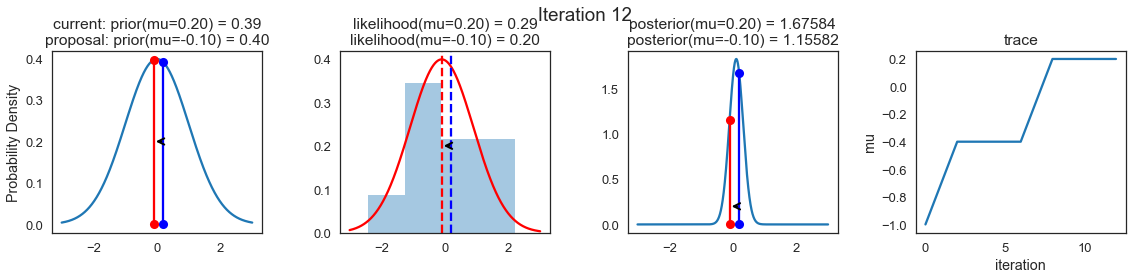

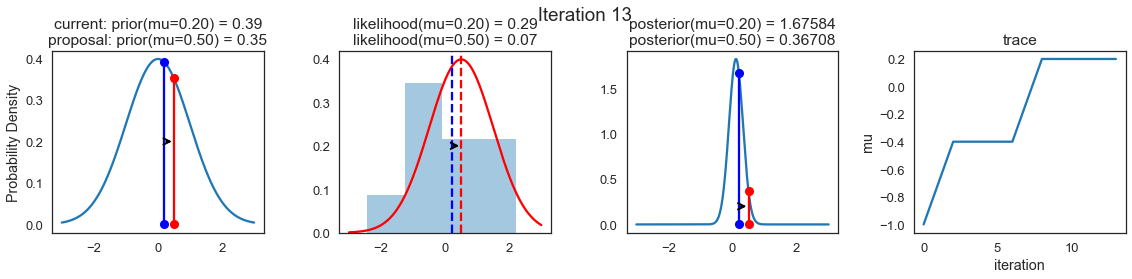

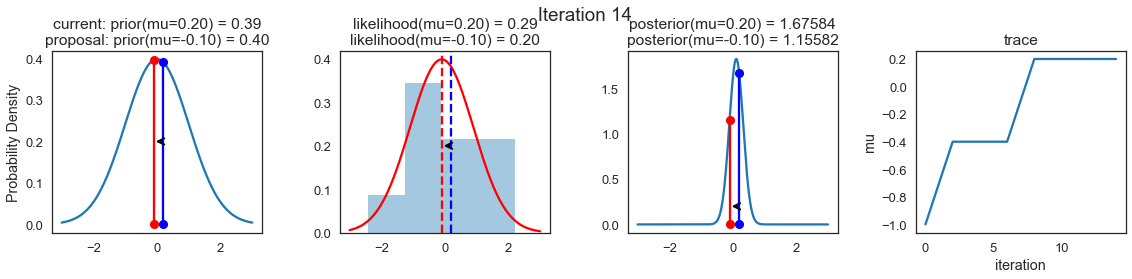

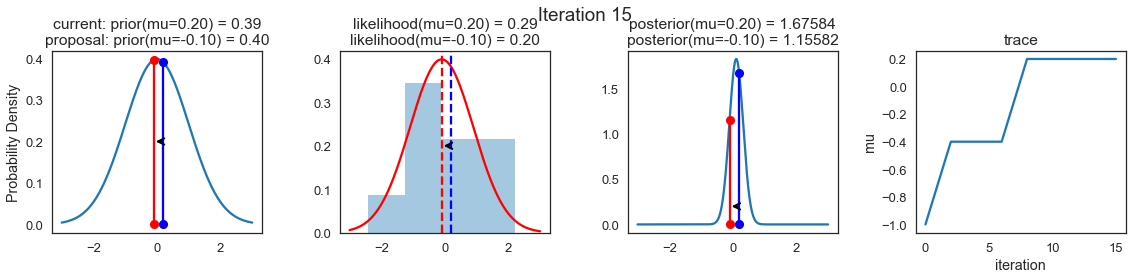

In [6]:
# create sample data
np.random.seed(123)
data = np.random.randn(20)

# plot sample data
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

# create sampler
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = mu_current + np.random.choice([-.3,.3],1)

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = 1 if p_accept >= 1 else 0
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior


# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('       Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

sampler(data, samples=15, mu_init=-1., plot=True);

We're almost done! So far we've developed a hill climbing algorithm that will get us to a maximal point along the posterior. This is cool, but it's not what we want! We want the whole posterior distribution. To do this we change our acceptance criteria. Instead of only accepting proposal values that are more likely than our current values, we'll accept proposal values with a probability proportional to their relatively probability of coming from the posterior as compared to current values. 

For example, it our proposal is half as likely to ahve come from our posterior as our current value, we would have previously always rejected it. Under this new methodology, we have a 50% chance of accepting or rejecting it. This way as we travel, our markov chain will visit values with a probability relative to their probability of coming from the posterior. If we sampled into infinity, we would recreate the posterior! Instead, we'll just sample a lot. 

Those familiar with machine learning will have naturally already drawn a connection between our proposal step size and a learning rate (conceptually they are the same thing). Remember that when we start training models using bayesian methods! It's also worth noting that the MH step size acts kile a hyper parameter of our sampler. If the step size is too small, we run the risk of sampling taking a long time and/or getting stuck on a local maxima (if our psoterior has a local maxima). If the step size if too large, we run the risk on never converging to the MAP. 

More advanced samplers solve this problem in more inventive ways. here, we'll just sample step size from a gaussian so that the step size is dynamic. Let's create the same view as above, but with our new step size and acceptance criteria. We print the same charts, but you should notice that the trace no longer monotonically increases. 

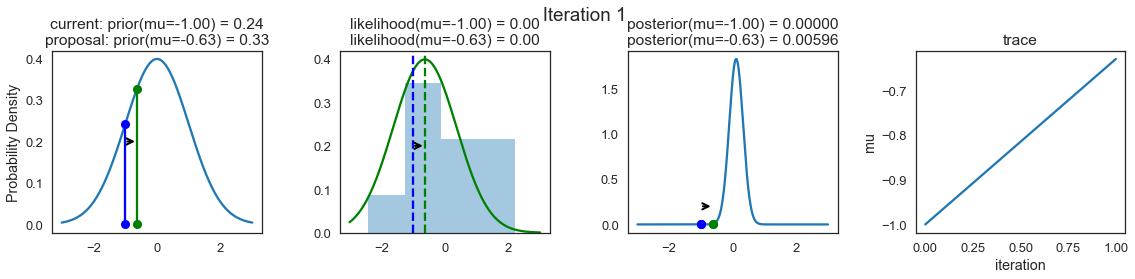

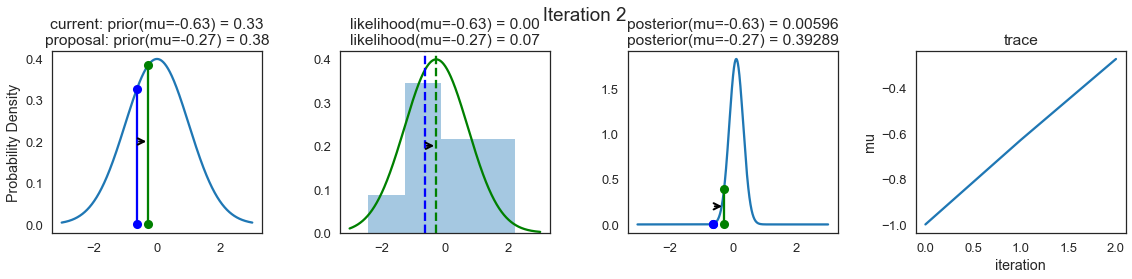

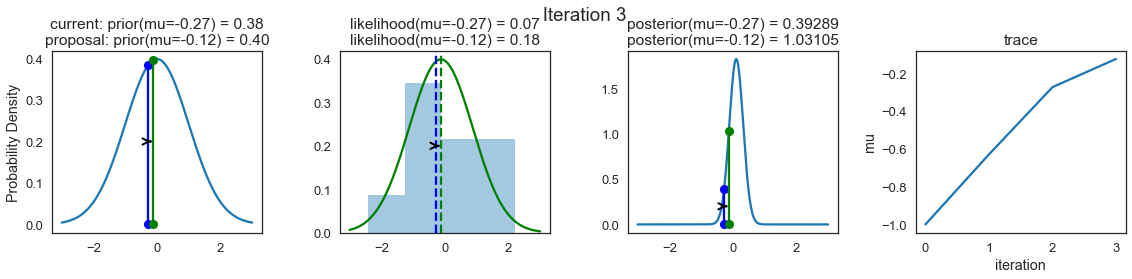

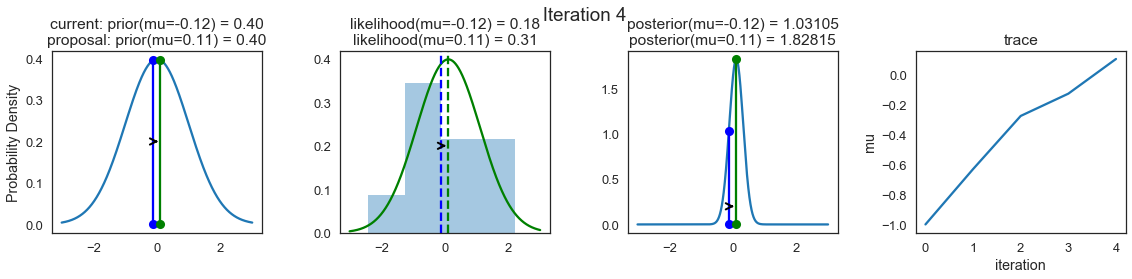

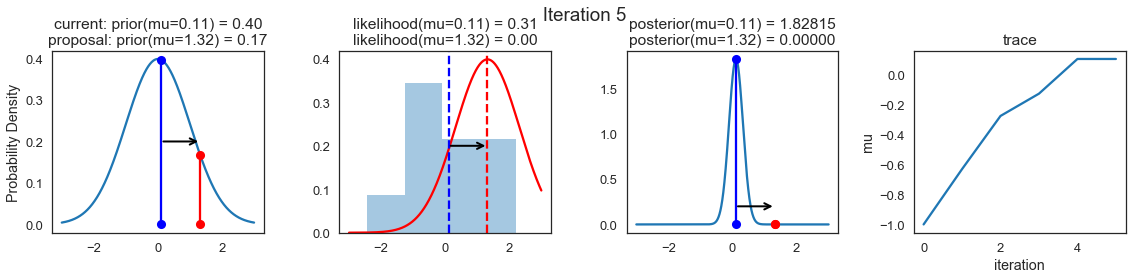

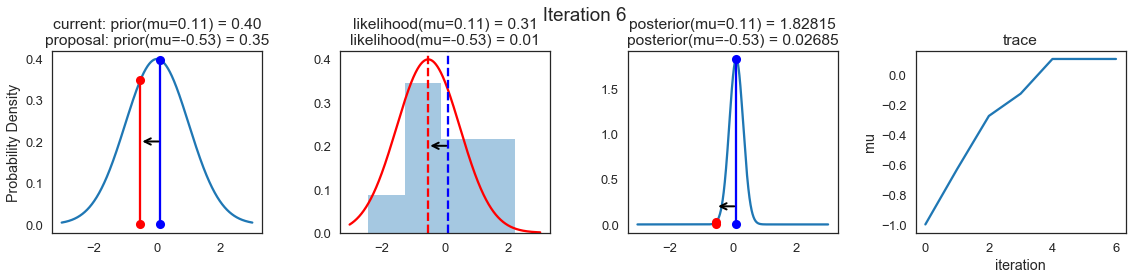

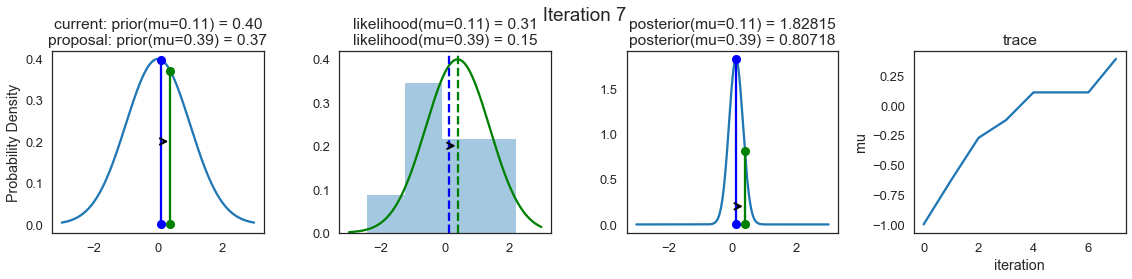

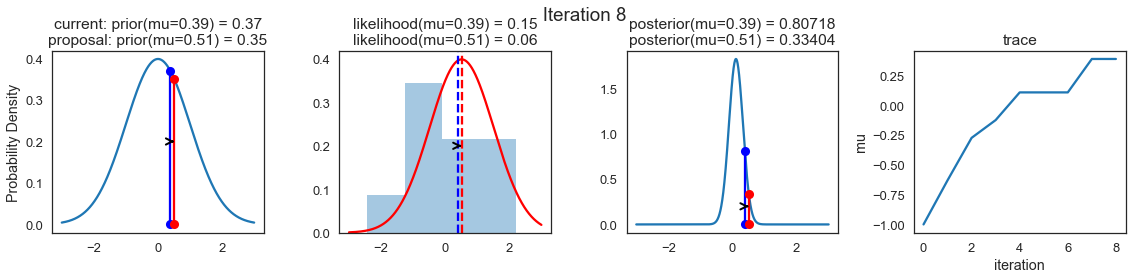

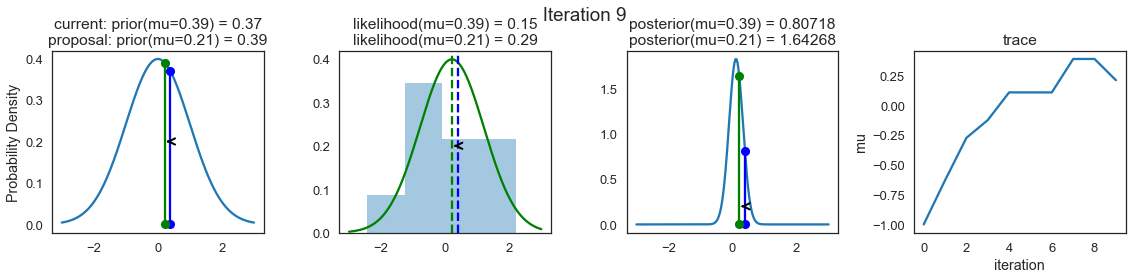

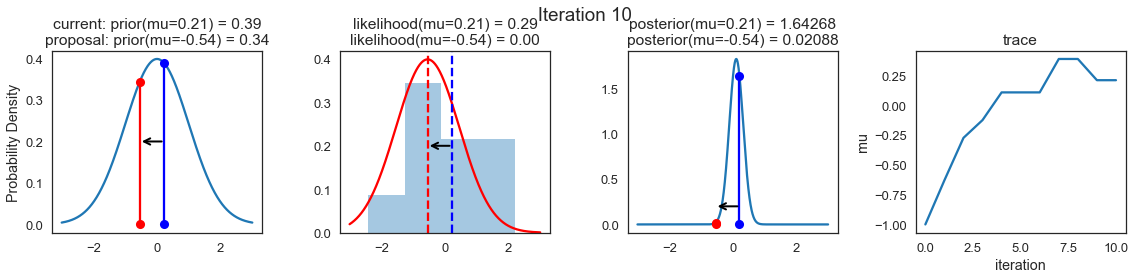

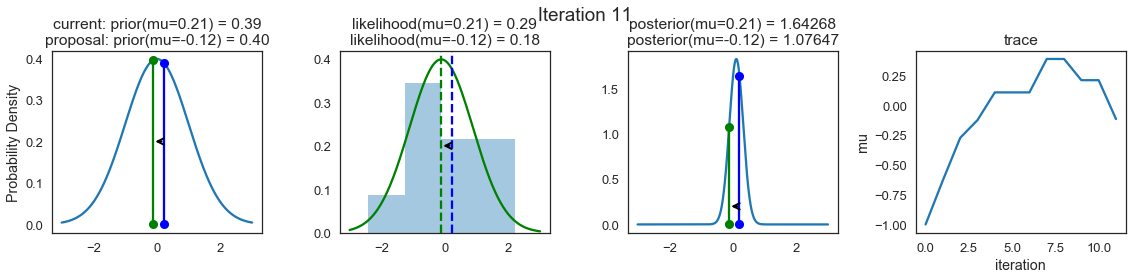

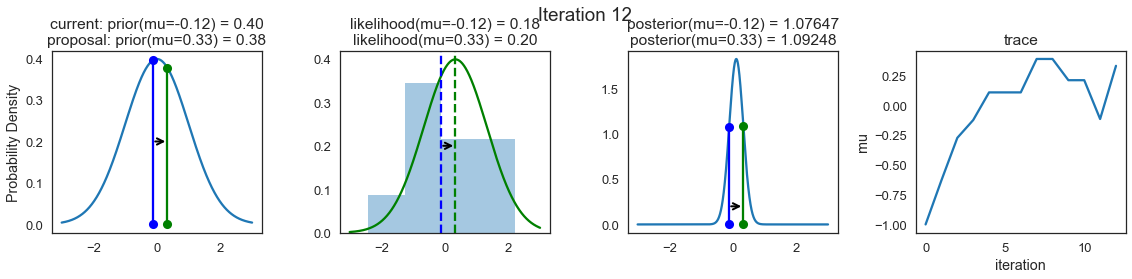

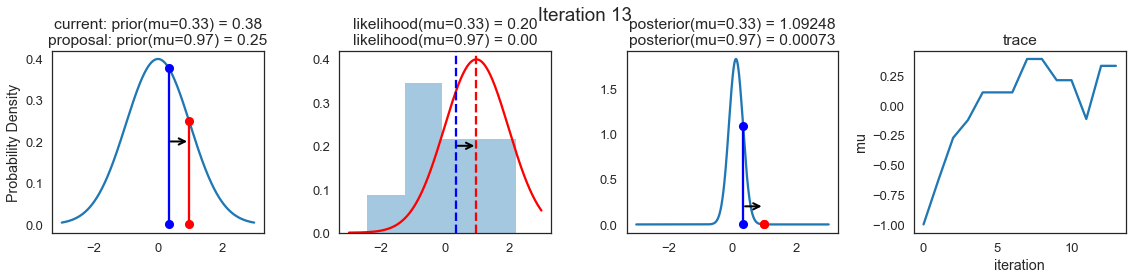

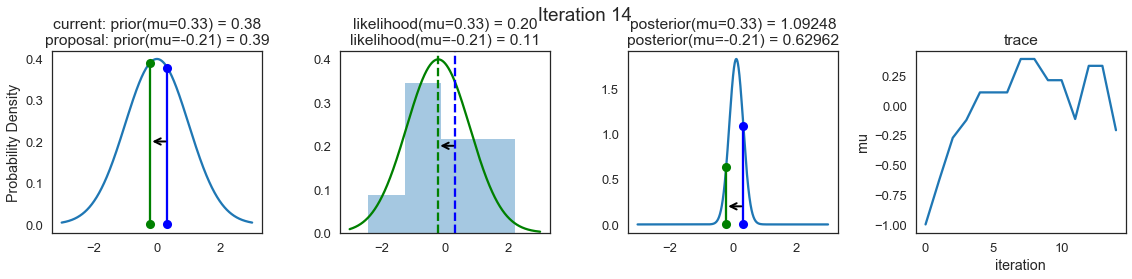

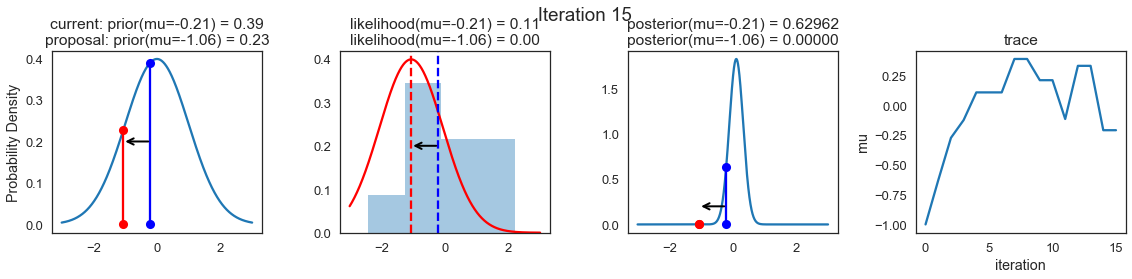

In [7]:
# create sampler
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current,proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior


# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('       Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

sampler(data, samples=15, mu_init=-1., plot=True);

Let's run this for 15000 iterations and then plot our trace (marov chain). Don't worry if this takes a bit, python is slow and we're generating a LOT of samples. We expect that this trace should converge about the MAP (and indeed that is what we see). 

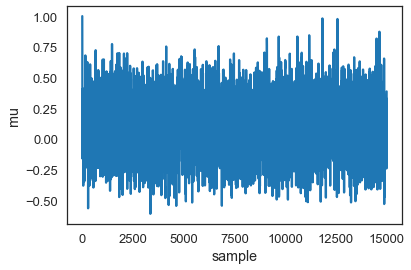

In [8]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu')

Now our sampling method comes with some baggage. Firstly, we start our sampling at some random place. This place may be very far away from the MAP and it may take many sample iterations to converge. These first X number of samples should be discarded. We'll discard the first thousand for good measure. 

In [9]:
posterior = posterior[1000:]

We can also note that our sampling method depends on a step size. This means that we can expect some autocorrelation between samples (similar to a random walk model). While this stochastic process is helpful in sampling, the autocorrolation is an undesirable after effect. Let's plot the Partial Autocorrelation Function of our trace at varying lags. We'll notice that there is a high coefficient value at zero...well of course! Each point is perfectly correlated with itself. We also notice a high value at a lag of one. This means that trace values are highly correlated with adjacent values. To combat this, we discard every second value in the trace. 

A myriad of features can affect the auto correlation in our trace. You may need to discard every five or siz values. Just remember to check that 1) your trace converges to a MAP and 2) that you are properly dealing with auto correlation in sampling. It is common to pull multiple markov chains (traces) and compare for convergence. We will do this in a later example. 

/Users/kgh094/anaconda/envs/test-env/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


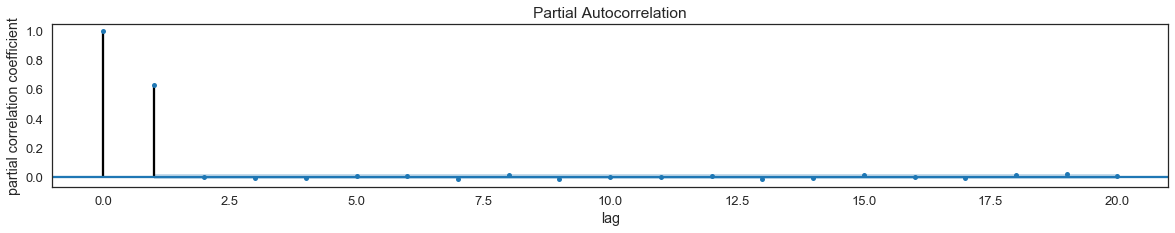

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(20,3))
plt.xlabel('lag')
plt.ylabel('partial correlation coefficient')
_ = plot_pacf(posterior, lags=20,  ax=ax)
plt.show()

# discard every 2nd value
posterior = posterior[0::2]

One additional measure that we could take (although I skip it here) is to look at the acceptance ratio for our MCMC sampling. The rule of thumb is to ahve this ratio in the 20-40% range. If you have a different acceptance ratio, you run the risk of getting stuck on a local maxima or failing to converge (there is still some risk of these if your acceptance ratio in between 20-40%). We can tune the acceptance ratio by increasing or decreasing the step sizes.

Here is a chart of autocorrelation in our model for different step sizes we could set. 

<img src="download.png" width="50%">

Finally, we plot our posterior of the mean. Does it look like the analytical solution we arrived at in the last example? Try pulling the MAP and comparing it to the last example. If you think you have the hang of this, try coding up a MH sampler to sovle the coin flip problem! What is the probability of getting heads on the next flip?

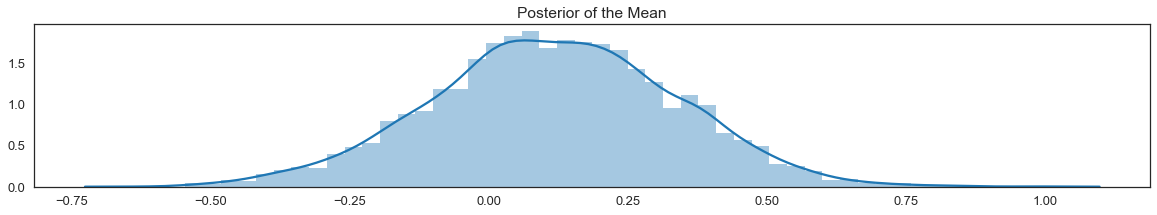

In [11]:
plt.figure(figsize=(20,3))
sns.distplot(posterior)
plt.title('Posterior of the Mean')
plt.show()

Reference: Example by [Thomas Wiecki](https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)

###### Bayes: My Friends Edward,  Stan, and Pymc3
Now that we've coded up our own MH sampler, we can all agree to never do it again (just kidding, I thought it was super fun)! It turns out that there are a bush load of statistical modeling packages out there to 1) help otimize our sampling for speed/efficiency and 2) let us use much more complicated/powerful sampling methods. We may discuss some of there more advanced sampling methods in later examples (frankly, they can get quite math intensive). For now, let's meet our contestants.

Pymc3 is a classic. You'll find a ton of source code and tutorials out there using pymc3. It has a lot of useful features and a syntax that is very intuitive. Unfortunately, it's relatively slow. Additionally, it uses theano (a no longer supported package for deep learning) on the backend. It's easy to pick up pymc3 and will help you work through a ton of examples out on the internet, but for a production grade model we'll need to put on our big boy pants.

Stan is pretty neat. With support for a variety of languages including R and python, it's really the bell of the ball. The template syntax takes some getting sued to as it is takes commands in the C++ syntax. Fortuantely, you don't need to learn to code in C++. Stan is fast and rather versatile. It was built for sampling, and by-gosh that's what it does. It's worth noting that while pymc3 supports a number of different samplers, stan implements the NUTs (no u turn) sampler. This is a reather new sampler that is very efficient.

Finally, there is Edward. Edward is a lot like pymc3, except that it's backend is tensorflow. Much of Edward is already being integrated into tensorflow contrib. We'll make use of edward when we get to neural nets. 

Finally part two...home built samplers. There may always be a case where none of these samplers meet your needs. I myself have had to code up a special gibbs sampler (a special case of a MH sampler) to meet certain model latency requirements. 

Let's run through the last example (normal conjugate prior) using each of these languages. As you run through this code, take note of how fast each sampler is. 

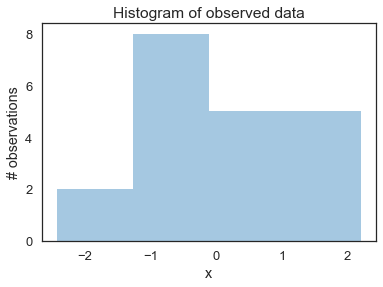

100%|██████████| 15500/15500 [00:02<00:00, 6015.73it/s]


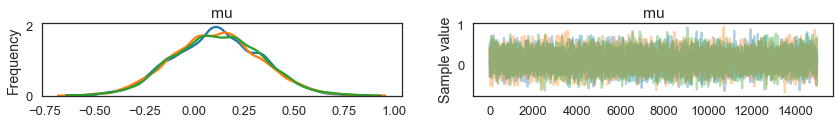

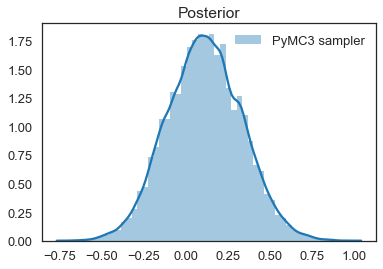

MAP: 0.01
AVG: 0.110750672855


In [15]:
# pymc3

import pymc3 as pm
from scipy import stats

# create sample data
np.random.seed(123)
data = np.random.randn(20)

# plot sample data
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');
plt.show()

# create the model object
with pm.Model():
    # define the prior for the mean
    mu = pm.Normal('mu', 0, 1)
    # assume we know the std is 1
    sigma = 1.
    # define the liklihood
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    # set our sampling methodology (default is NUTs)
    step = pm.Metropolis()
    # sample to create the trace
    trace = pm.sample(15000, step, njobs=3) # increase the number of jobs to check if they converge
    
_ = pm.traceplot(trace)
plt.show()

sns.distplot(trace[1000:]['mu'], label='PyMC3 sampler');
plt.title('Posterior')
plt.legend();
plt.show()

print "MAP: {}".format( stats.mode( np.round(trace[1000:]['mu'],2) )[0][0] )
print "AVG: {}".format( np.mean(trace[1000:]['mu']) )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d94685f6d5fe05b270bcfd3ddfd467e6 NOW.


In file included from /var/folders/d1/nc2x79hd10q2173078w0ny6xm6nhbm/T/tmprahXLB/stanfit4anon_model_d94685f6d5fe05b270bcfd3ddfd467e6_2300388982451800886.cpp:559:
In file included from /Users/kgh094/anaconda/envs/test-env/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/kgh094/anaconda/envs/test-env/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Users/kgh094/anaconda/envs/test-env/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/Users/kgh094/anaconda/envs/test-env/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
In file included from /var/folders/d1/nc2x79hd10q2173078w0ny6xm6nhbm/T/tmprahXLB/stanfit4anon_model_d94685f6d5fe05b270bcfd3ddfd467e6_

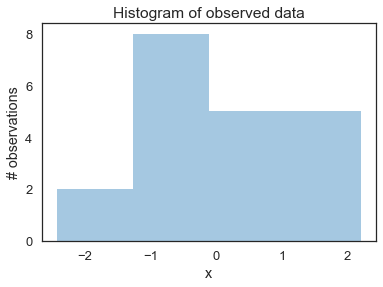

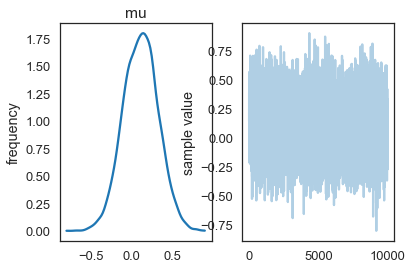

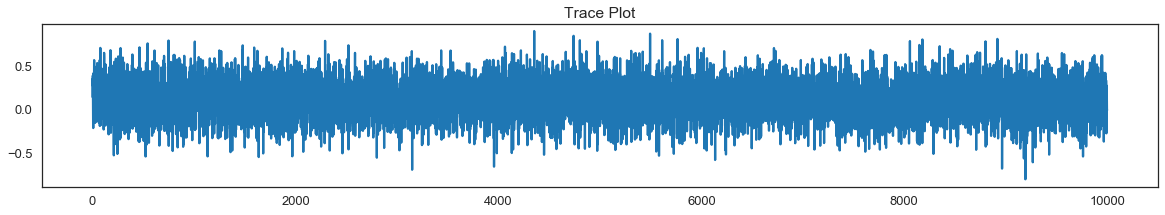

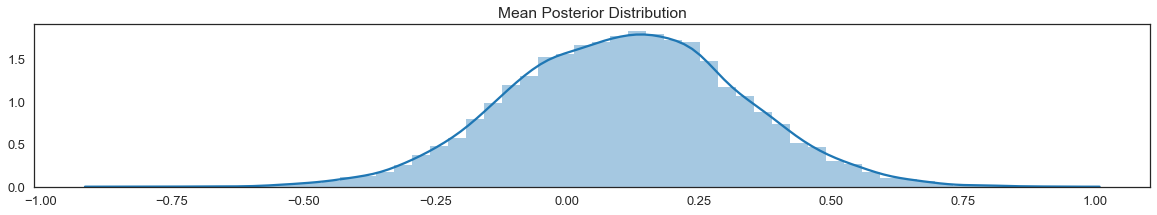

MAP: 0.13
AVG: 0.109658813107


In [18]:
# Stan

import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# create sample data
np.random.seed(123)
data = np.random.randn(20)

# plot sample data
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

# define model template for stan (in C++)
modelString = """
data {
    int<lower=0> N ; // length of data set
    real y[N] ; // observations
    }
parameters {
    real mu; // parameter we want to estimate
    } 
model {
    mu ~ normal(0,1) ; // prior for mu
    y ~ normal(mu, 1) ; // posterior
    }
"""

# pass our template to stan
sm = pystan.StanModel(model_code=modelString)

# organize our input variables in a dictionary
data = { 'N': len(data),
         'y': data
       }

# pass input data, iteration number, and number of chains to sample to stan
fit = sm.sampling(data=data, iter=5000, chains=4)

# exstract traces from stan model as a dictionary of traces
la = fit.extract(permuted=True)

# plot traces
fit.plot()
plt.show()

plt.figure(figsize=(20,3))
plt.plot(la['mu'])
plt.title('Trace Plot')
plt.show()

plt.figure(figsize=(20,3))
sns.distplot(la['mu'])
plt.title('Mean Posterior Distribution')
plt.show()

print "MAP: {}".format( stats.mode( np.round(la['mu'],2) )[0][0] )
print "AVG: {}".format( np.mean(la['mu']) )

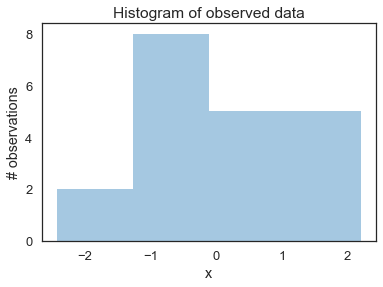

15000/15000 [100%] ██████████████████████████████ Elapsed: 15s | Acceptance Rate: 0.850


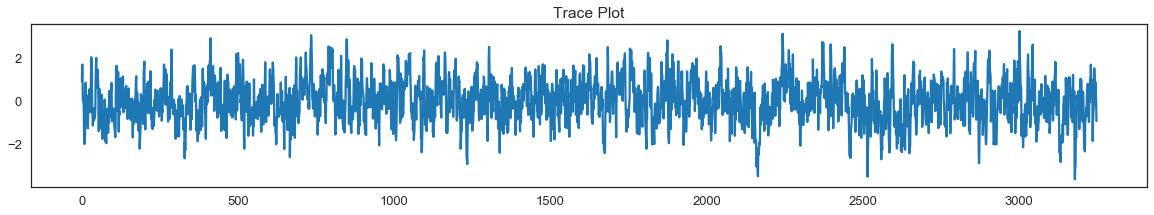

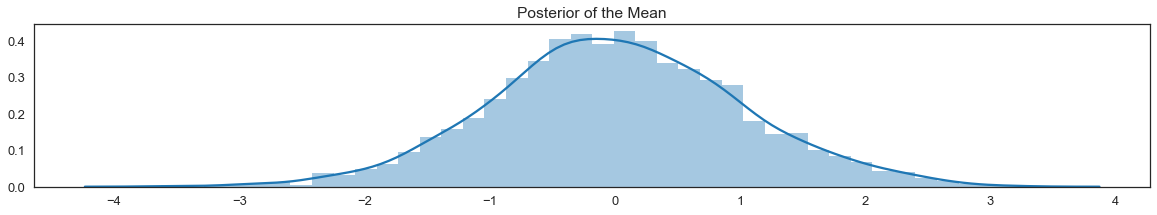

MAP: 0.310000002384
AVG: 0.0112438211218


In [17]:
# Edward
import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Normal

# create sample data
np.random.seed(123)
data = np.random.randn(20)
N = len(data)

# plot sample data
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');
plt.show()

# create a latent variable for the data
x = tf.placeholder(tf.float32, [N, 1])

# create a tensor object with our data
x_train = np.zeros((N, 1), dtype=np.float32)
for n in range(N):
    x_train[n] = data[n]

# create a latent variable
mu = Normal(tf.zeros(1), tf.ones(1))
qmu = ed.models.Empirical(tf.Variable(tf.zeros([15000,1])))

# initialize our step size for proposals (.5 in this case)
proposal_mu = Normal(loc=mu, scale=0.5)

inference = ed.MetropolisHastings({mu: qmu}, {mu: proposal_mu}, data={x: x_train})
inference.initialize(n_iter=15000)

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        #print("\nEstimated Mean:")
        #print(sess.run(running_cluster_means, {t_ph: t - 1}))
        pass
    
thin=4
burnin=2000
qmu_trace = qmu.params.eval()[burnin::thin]

plt.figure(figsize=(20,3))
plt.title('Trace Plot')
plt.plot( qmu_trace )
plt.show()

plt.figure(figsize=(20,3))
plt.title('Posterior of the Mean')
sns.distplot( qmu_trace )
plt.show()

print "MAP: {}".format( stats.mode( np.round(qmu_trace,2) )[0][0][0] )
print "AVG: {}".format( np.mean( qmu_trace ) )

To get a bit of practice with these languages, pick your favorite and try to solve the coin flip problem. What is the probability of getting heads on the next flip? 